In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [41]:
data = pd.read_csv('cryptocurrency-price-direction-predictor/train.csv')
data

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,0.0
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,0.0
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2122433,1652817240,0.43060,0.43060,0.42990,0.43040,136274.00,58630.162800,144.0,54216.00,23325.927700,1.0
2122434,1652817300,0.43030,0.43070,0.43030,0.43050,104478.00,44967.837600,99.0,52232.00,22484.030400,1.0
2122435,1652817360,0.43050,0.43120,0.43050,0.43090,212396.00,91526.987200,177.0,108324.00,46673.061600,0.0
2122436,1652817420,0.43110,0.43110,0.43040,0.43060,131047.00,56443.003800,107.0,32713.00,14097.148900,0.0


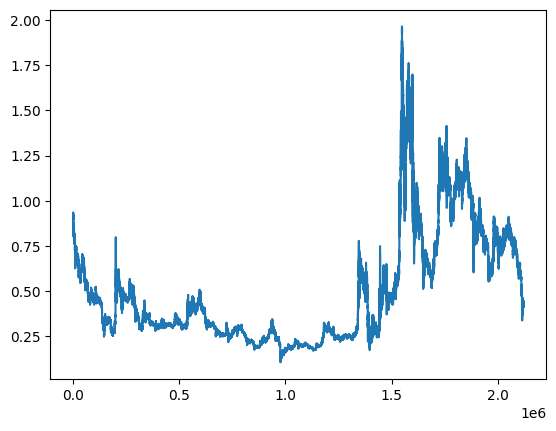

In [81]:
rows, cols = 2, 2
plt.plot(data['close'])
plt.show()

In [42]:
def outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  df = df[(df[col] >= lower) & (df[col] <= upper)]
  return df
data = outliers(data, 'close')

In [43]:
def createFeatures(df):
    data = pd.DataFrame(df)

    # rolling avgs
    data['MA50'] = data['close'].rolling(window=50).mean()
    data['MA20'] = data['close'].rolling(window=20).mean()

    # exponential moving avgs
    data['EMA50'] = data['close'].ewm(span=50, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
    data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()

    # macd
    data['MA20STD'] = data['close'].rolling(window=20).std()

    # prev data
    data['close_shift_1'] = data.shift(-1)['close']
    data['close_shift_2'] = data.shift(-2)['close']
    data['close_shift_3'] = data.shift(-3)['close']
    data['close_shift_5'] = data.shift(-5)['close']
    data['close_shift_10'] = data.shift(-10)['close']

    # bollinger
    data['bollinger_upper'] = data['MA20'] + (data['MA20STD'] * 2)
    data['bollinger_lower'] = data['MA20'] - (data['MA20STD'] * 2)

    # RSI
    #data = data.dropna()

    return data

data = createFeatures(data)
data

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,EMA26,EMA12,MA20STD,close_shift_1,close_shift_2,close_shift_3,close_shift_5,close_shift_10,bollinger_upper,bollinger_lower
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,...,0.901300,0.901300,NaN,0.90195,0.90139,0.90139,0.90001,0.89979,NaN,NaN
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,...,0.901348,0.901400,NaN,0.90139,0.90139,0.90130,0.89808,0.89968,NaN,NaN
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,...,0.901351,0.901398,NaN,0.90139,0.90130,0.90001,0.90000,0.89956,NaN,NaN
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,...,0.901354,0.901397,NaN,0.90130,0.90001,0.89808,0.90000,0.89734,NaN,NaN
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,...,0.901350,0.901382,NaN,0.90001,0.89808,0.90000,0.89979,0.89734,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122433,1652817240,0.43060,0.43060,0.42990,0.43040,136274.00,58630.162800,144.0,54216.00,23325.927700,...,0.430929,0.430606,0.001255,0.43050,0.43090,0.43060,NaN,NaN,0.433844,0.428826
2122434,1652817300,0.43030,0.43070,0.43030,0.43050,104478.00,44967.837600,99.0,52232.00,22484.030400,...,0.430897,0.430590,0.001203,0.43090,0.43060,0.43010,NaN,NaN,0.433617,0.428803
2122435,1652817360,0.43050,0.43120,0.43050,0.43090,212396.00,91526.987200,177.0,108324.00,46673.061600,...,0.430898,0.430637,0.001137,0.43060,0.43010,NaN,NaN,NaN,0.433384,0.428836
2122436,1652817420,0.43110,0.43110,0.43040,0.43060,131047.00,56443.003800,107.0,32713.00,14097.148900,...,0.430875,0.430632,0.001029,0.43010,NaN,NaN,NaN,NaN,0.433038,0.428922


In [52]:
def process_time(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data['hour'] = data['timestamp'].dt.hour
    data['minute'] = data['timestamp'].dt.minute
    data.drop('timestamp', axis=1, inplace=True)
    return data
data = process_time(data)

In [49]:
data.corr()['target']

timestamp                 0.005240
open                     -0.006602
high                     -0.006572
low                      -0.006660
close                    -0.006690
volume                    0.014575
quote_asset_volume        0.011954
number_of_trades          0.013843
taker_buy_base_volume     0.012854
taker_buy_quote_volume    0.010437
target                    1.000000
MA50                     -0.006377
MA20                     -0.006465
EMA50                    -0.006411
EMA26                    -0.006468
EMA12                    -0.006532
MA20STD                   0.011319
close_shift_1            -0.004948
close_shift_2            -0.004974
close_shift_3            -0.004996
close_shift_5            -0.004993
close_shift_10           -0.005011
bollinger_upper          -0.006303
bollinger_lower          -0.006628
Name: target, dtype: float64

In [51]:
data

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,EMA26,EMA12,MA20STD,close_shift_1,close_shift_2,close_shift_3,close_shift_5,close_shift_10,bollinger_upper,bollinger_lower
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,...,0.901300,0.901300,NaN,0.90195,0.90139,0.90139,0.90001,0.89979,NaN,NaN
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,...,0.901348,0.901400,NaN,0.90139,0.90139,0.90130,0.89808,0.89968,NaN,NaN
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,...,0.901351,0.901398,NaN,0.90139,0.90130,0.90001,0.90000,0.89956,NaN,NaN
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,...,0.901354,0.901397,NaN,0.90130,0.90001,0.89808,0.90000,0.89734,NaN,NaN
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,...,0.901350,0.901382,NaN,0.90001,0.89808,0.90000,0.89979,0.89734,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122433,1652817240,0.43060,0.43060,0.42990,0.43040,136274.00,58630.162800,144.0,54216.00,23325.927700,...,0.430929,0.430606,0.001255,0.43050,0.43090,0.43060,NaN,NaN,0.433844,0.428826
2122434,1652817300,0.43030,0.43070,0.43030,0.43050,104478.00,44967.837600,99.0,52232.00,22484.030400,...,0.430897,0.430590,0.001203,0.43090,0.43060,0.43010,NaN,NaN,0.433617,0.428803
2122435,1652817360,0.43050,0.43120,0.43050,0.43090,212396.00,91526.987200,177.0,108324.00,46673.061600,...,0.430898,0.430637,0.001137,0.43060,0.43010,NaN,NaN,NaN,0.433384,0.428836
2122436,1652817420,0.43110,0.43110,0.43040,0.43060,131047.00,56443.003800,107.0,32713.00,14097.148900,...,0.430875,0.430632,0.001029,0.43010,NaN,NaN,NaN,NaN,0.433038,0.428922


In [53]:
def filter_data(df):
    features = ['hour', 'minute', 'open', 'high', 'low', 'close', 'target', 'MA50',
            'MA20', 'EMA50', 'EMA26',  'close_shift_1',
            'close_shift_2', 'close_shift_3', 'close_shift_5', 'close_shift_10',
                'volume', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_volume',
                'taker_buy_quote_volume',
                'bollinger_upper', 'bollinger_lower']
    df = df[features]
    return df

data = filter_data(data)
data

,hour,minute,open,high,low,close,target,MA50,MA20,EMA50,...,close_shift_3,close_shift_5,close_shift_10,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,bollinger_upper,bollinger_lower
0,22,1,0.90120,0.90130,0.90120,0.90130,1.0,NaN,NaN,0.901300,...,0.90139,0.90001,0.89979,134.98,121.646459,4.0,125.08,112.723589,NaN,NaN
1,22,2,0.90185,0.90195,0.90185,0.90195,0.0,NaN,NaN,0.901325,...,0.90130,0.89808,0.89968,1070.54,965.505313,12.0,879.94,793.612703,NaN,NaN
2,22,3,0.90140,0.90140,0.90139,0.90139,0.0,NaN,NaN,0.901328,...,0.90001,0.90000,0.89956,2293.06,2066.963991,5.0,0.00,0.000000,NaN,NaN
3,22,4,0.90139,0.90140,0.90138,0.90139,0.0,NaN,NaN,0.901330,...,0.89808,0.90000,0.89734,6850.59,6175.000909,19.0,1786.30,1610.149485,NaN,NaN
4,22,5,0.90139,0.90139,0.90130,0.90130,0.0,NaN,NaN,0.901329,...,0.90000,0.89979,0.89734,832.30,750.222624,3.0,784.82,707.428900,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122433,19,54,0.43060,0.43060,0.42990,0.43040,1.0,0.431162,0.431335,0.430399,...,0.43060,NaN,NaN,136274.00,58630.162800,144.0,54216.00,23325.927700,0.433844,0.428826
2122434,19,55,0.43030,0.43070,0.43030,0.43050,1.0,0.431200,0.431210,0.430403,...,0.43010,NaN,NaN,104478.00,44967.837600,99.0,52232.00,22484.030400,0.433617,0.428803
2122435,19,56,0.43050,0.43120,0.43050,0.43090,0.0,0.431238,0.431110,0.430423,...,NaN,NaN,NaN,212396.00,91526.987200,177.0,108324.00,46673.061600,0.433384,0.428836
2122436,19,57,0.43110,0.43110,0.43040,0.43060,0.0,0.431246,0.430980,0.430430,...,NaN,NaN,NaN,131047.00,56443.003800,107.0,32713.00,14097.148900,0.433038,0.428922


In [54]:
X, y = data.drop(columns=['target']), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest Classifier Performance:
Accuracy: 0.7631532204495076
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.82      0.78    215545
         1.0       0.78      0.70      0.74    195438

    accuracy                           0.76    410983
   macro avg       0.77      0.76      0.76    410983
weighted avg       0.76      0.76      0.76    410983

Confusion Matrix:
 [[177419  38126]
 [ 59214 136224]]


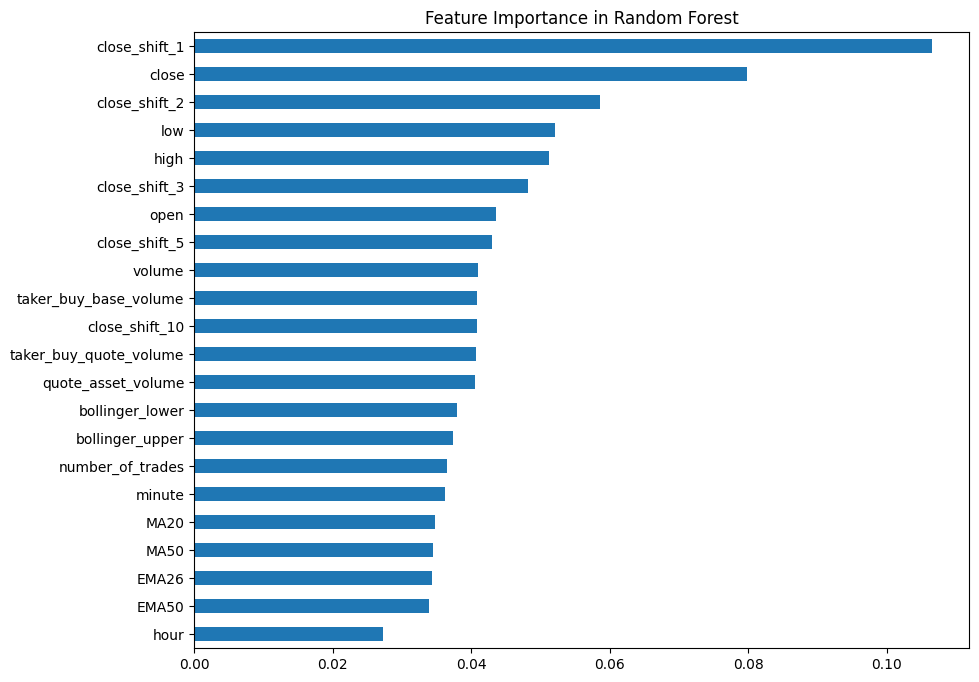

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(10, 8), title='Feature Importance in Random Forest')
plt.show()


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    'n_estimators': [50, 100, 150, 200],              
    'max_depth': [5, 10, None],                    
    'max_features': ['sqrt'],    
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=2)


grid_search.fit(X_train_scaled, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Python(48526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(48537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time= 8.1min
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time= 8.3min
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time= 8.4min
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=16.8min
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=16.9min
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=17.2min
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=75.9min
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=150; total time=92.2min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=50; total time=146.4min
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=50; total time=146.9min
[CV] END ..max_depth=5, max_features=sqrt, n_estimators=150; total time=156.2min
[CV] END ..max_depth=5, max_features=sqrt, n_estimators=200; total time=184.2min
[CV] END ..max_depth=5, max_

In [36]:
test = pd.read_csv('cryptocurrency-price-direction-predictor/test.csv')
#test = outliers(test, 'close')
test = createFeatures(test)
test = process_time(test)

In [23]:
test.shape

(909617, 25)

In [24]:
test

,row_id,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,MA20STD,close_shift_1,close_shift_2,close_shift_3,close_shift_5,close_shift_10,bollinger_upper,bollinger_lower,hour,minute
0,0,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237,...,NaN,0.4302,0.4299,0.4301,0.4306,0.4302,NaN,NaN,19,58
1,1,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312,...,NaN,0.4299,0.4301,0.4303,0.4304,0.4301,NaN,NaN,19,59
2,2,0.4302,0.4302,0.4292,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448,...,NaN,0.4301,0.4303,0.4306,0.4302,0.4299,NaN,NaN,20,0
3,3,0.4299,0.4303,0.4299,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691,...,NaN,0.4303,0.4306,0.4304,0.4306,0.4301,NaN,NaN,20,1
4,4,0.4302,0.4307,0.4302,0.4303,107440.0,46243.7993,113.0,31096.0,13384.3384,...,NaN,0.4306,0.4304,0.4302,0.4307,0.4302,NaN,NaN,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909612,909612,0.5141,0.5144,0.5141,0.5143,115358.0,59321.7124,64.0,103183.0,53061.6505,...,0.000696,0.5143,0.5142,0.5143,NaN,NaN,0.515007,0.512223,12,10
909613,909613,0.5144,0.5144,0.5142,0.5143,100017.0,51433.4744,59.0,29333.0,15084.3792,...,0.000691,0.5142,0.5143,0.5144,NaN,NaN,0.515066,0.512304,12,11
909614,909614,0.5143,0.5144,0.5142,0.5142,51665.0,26573.9877,46.0,33916.0,17445.9911,...,0.000650,0.5143,0.5144,NaN,NaN,NaN,0.515065,0.512465,12,12
909615,909615,0.5143,0.5144,0.5143,0.5143,28063.0,14433.0717,35.0,16810.0,8645.6538,...,0.000587,0.5144,NaN,NaN,NaN,NaN,0.515029,0.512681,12,13


In [37]:
def filter_data_test(df):
    features = ['hour', 'minute', 'open', 'high', 'low', 'close', 'MA50',
            'MA20', 'EMA50', 'EMA26',  'close_shift_1',
            'close_shift_2', 'close_shift_3', 'close_shift_5', 'close_shift_10',
                'volume', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_volume',
                'taker_buy_quote_volume',
                'bollinger_upper', 'bollinger_lower']
    df = df[features]
    return df


test = filter_data_test(test)
test

,hour,minute,open,high,low,close,MA50,MA20,EMA50,EMA26,...,close_shift_3,close_shift_5,close_shift_10,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,bollinger_upper,bollinger_lower
0,19,58,0.4306,0.4308,0.4301,0.4301,NaN,NaN,0.430100,0.430100,...,0.4301,0.4306,0.4302,101150.0,43542.2629,105.0,46109.0,19851.7237,NaN,NaN
1,19,59,0.4301,0.4303,0.4293,0.4302,NaN,NaN,0.430104,0.430107,...,0.4303,0.4304,0.4301,275647.0,118478.9689,228.0,91260.0,39217.6312,NaN,NaN
2,20,0,0.4302,0.4302,0.4292,0.4299,NaN,NaN,0.430096,0.430092,...,0.4306,0.4302,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448,NaN,NaN
3,20,1,0.4299,0.4303,0.4299,0.4301,NaN,NaN,0.430096,0.430093,...,0.4304,0.4306,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691,NaN,NaN
4,20,2,0.4302,0.4307,0.4302,0.4303,NaN,NaN,0.430104,0.430108,...,0.4302,0.4307,0.4302,107440.0,46243.7993,113.0,31096.0,13384.3384,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909612,12,10,0.5141,0.5144,0.5141,0.5143,0.513472,0.513615,0.513781,0.513761,...,0.5143,NaN,NaN,115358.0,59321.7124,64.0,103183.0,53061.6505,0.515007,0.512223
909613,12,11,0.5144,0.5144,0.5142,0.5143,0.513468,0.513685,0.513802,0.513801,...,0.5144,NaN,NaN,100017.0,51433.4744,59.0,29333.0,15084.3792,0.515066,0.512304
909614,12,12,0.5143,0.5144,0.5142,0.5142,0.513454,0.513765,0.513817,0.513831,...,NaN,NaN,NaN,51665.0,26573.9877,46.0,33916.0,17445.9911,0.515065,0.512465
909615,12,13,0.5143,0.5144,0.5143,0.5143,0.513440,0.513855,0.513836,0.513865,...,NaN,NaN,NaN,28063.0,14433.0717,35.0,16810.0,8645.6538,0.515029,0.512681


In [40]:
X = test
idx = X.index
X = scaler.transform(X)
preds = best_rf_model.predict(X)
predictions_df = pd.DataFrame({
    'row_id': idx,  
    'target': preds
})

predictions_df.to_csv('predictions.csv', index=False)